In [2]:
import sys
import os
import pandas as pd
import datetime as datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import OneHotEncoder
import matplotlib
import matplotlib.pyplot as plt
#import psycopg2
from scipy.stats import ks_2samp
import scipy.stats as scats
#from scipy.stats import boxcox
import visuals as vs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from heapq import nlargest
from sklearn.model_selection import GridSearchCV

plt.style.use('ggplot') 
%matplotlib inline

## INTEGRATE DATA FROM LABS AND CHARTS
Data from labs and charts have been previously aggregated and summarized (variables with multiple measurements have had mean, std, skewness etc calculated). Data is integrated/merged into a single data_frame. 

## FEATURE SELECTION
Feature selection tools, including SelectKBest, require data sets to be full (no NaN values)and to be of the same type (continuous/categorical). To reduce the dimensionality of our data and select the most relevant features, data is then broken out into blocks according to data type. Because not all data was collected for all icu stays or patients there are gaps such that there are very few icu stays for which there are no NaN values. There were patterns of data collection however, groups of variables that were most often collected together (likely the results of the condition, the type of ICU etc). To generate full sets of data for feature selection, the data is further broken down into blocks of variables most often collected together. 

In [12]:
features_dir = os.getcwd() + '/features/'
display(features_dir)
monkey = os.listdir(features_dir)
feature_files = [x for x in monkey if '.csv' in x]
display(feature_files )
features_dict = {}
for name in feature_files:
    features_dict[name.split('.')[0]] = pd.DataFrame.from_csv(features_dir + name)

'/Users/robertbeetel/anaconda/projects/mimic-code-master/mimic_analysis/features/'

['Chart_BP_Features.csv',
 'Chart_GCS_Features.csv',
 'Chart_GCSTotal_Features.csv',
 'Chart_HrRr_Features.csv',
 'Lab_AbnFlag_Features.csv',
 'Lab_CreatGlucHemWBC_Features.csv',
 'Lab_pHLacO2Sat_Features.csv']

In [21]:
key = features_dict.keys()[5]
display(key)
features_dict[key].head()


'Chart_GCSTotal_Features'

,hospital_expire_flag,pH3_mean_Q0,pH2_mean_Q0,pH3_mean_Q1,pH2_med_Q1,pH3_med_Q1,pH3_med_Q0,pH2_med_Q0,pH2_mean_Q1,pH3_max_Q0,...,pH2_min_Q1,pH3_min_Q1,pH2_first_Q1,pH3_mean_Q3,pH2_mean_Q3,pH2_med_Q3,pH3_med_Q3,pH2_skew_Q2,pH3_skew_Q2,pH2_first_Q2
icustay_id,,,,,,,,,,,,,,,,,,,,,
200003,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
200009,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
200014,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
200025,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
200062,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [22]:
ptnt_demog_data = pd.DataFrame.from_csv('PTNT_DEMOG_FIRST24_PROCESSED.csv')
print "ptnt_demog_data imported"
display(ptnt_demog_data.head())

ptnt_demog_data imported


,hadm_id,age,icu_stay,hosp_stay,subject_id,first_careunit,gender,marital_status,ethnicity,insurance,...,Conduction disorders,Chronic obstructive pulmonary disease and bronchiectasis,Pleurisy; pneumothorax; pulmonary collapse,Gastrointestinal hemorrhage,Respiratory failure; insufficiency; arrest (adult),Coronary atherosclerosis and other heart disease,Disorders of lipid metabolism,Shock,Essential hypertension,icustay_id
0,145834,76.0,146.0,259.0,3,MICU,M,MARRIED,WHITE,Medicare,...,0,0,0,0,0,0,0,0,0,211552
1,185777,48.0,41.0,187.0,4,MICU,F,SINGLE,WHITE,Private,...,0,0,0,0,0,0,0,0,0,294638
2,107064,66.0,89.0,393.0,6,SICU,F,MARRIED,WHITE,Medicare,...,0,0,0,0,0,0,0,0,0,228232
3,150750,41.0,128.0,118.0,9,MICU,M,NaN,UNKNOWN/NOT SPECIFIED,Medicaid,...,0,0,0,0,0,0,0,0,1,220597
4,112213,72.0,184.0,305.0,12,SICU,M,MARRIED,WHITE,Medicare,...,0,0,0,0,0,0,0,0,1,232669


In [27]:

ptnt_demog_data.head()

,hadm_id,age,icu_stay,hosp_stay,subject_id,first_careunit,gender,marital_status,ethnicity,insurance,...,Other lower respiratory disease,Conduction disorders,Chronic obstructive pulmonary disease and bronchiectasis,Pleurisy; pneumothorax; pulmonary collapse,Gastrointestinal hemorrhage,Respiratory failure; insufficiency; arrest (adult),Coronary atherosclerosis and other heart disease,Disorders of lipid metabolism,Shock,Essential hypertension
icustay_id,,,,,,,,,,,,,,,,,,,,,
211552,145834,76.0,146.0,259.0,3,MICU,M,MARRIED,WHITE,Medicare,...,0,0,0,0,0,0,0,0,0,0
294638,185777,48.0,41.0,187.0,4,MICU,F,SINGLE,WHITE,Private,...,0,0,0,0,0,0,0,0,0,0
228232,107064,66.0,89.0,393.0,6,SICU,F,MARRIED,WHITE,Medicare,...,0,0,0,0,0,0,0,0,0,0
220597,150750,41.0,128.0,118.0,9,MICU,M,NaN,UNKNOWN/NOT SPECIFIED,Medicaid,...,0,0,0,0,0,0,0,0,0,1
232669,112213,72.0,184.0,305.0,12,SICU,M,MARRIED,WHITE,Medicare,...,0,0,0,0,0,0,0,0,0,1


In [6]:
# IMPORT LAB AND CHART DATA THAT HAS BEEN COLLECTED FROM THE RECORDS AND SUMMARIZED (MEAN, STD ETC). 

chart_data = pd.DataFrame.from_csv('CHART_EVENTS_FIRST24_PROCESSED.csv')
print "chart_data imported"
display(chart_data.head())
lab_data = pd.DataFrame.from_csv('LAB_EVENTS_FIRST24_PROCESSED.csv')
print "lab_data imported"
display(lab_data.head())


chart_data imported


,icustay_id,subject_id,BP_Dia_max,BP_Dia_mean,BP_Dia_med,BP_Dia_min,BP_Dia_skew,BP_Dia_std,BP_Mean_max,BP_Mean_mean,...,pH2_med,pH2_min,pH2_skew,pH2_std,pH_max,pH_mean,pH_med,pH_min,pH_skew,pH_std
0,200001,55973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,200003,27513,81.0,42.708333,60.5,0.0,-0.623249,31.452489,179.0,87.411765,...,7.38,7.36,1.220037,0.038987,7.46,7.398,7.38,7.36,1.220037,0.038987
2,200006,10950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,200007,20707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,200009,29904,84.0,62.645161,57.0,49.0,0.868910,10.931753,101.0,74.741935,...,7.39,7.29,0.360059,0.071063,7.50,7.380,7.39,7.29,0.360059,0.071063


lab_data imported


,icustay_id,subject_id,Lactate_max_df,Lactate_mean_df,Lactate_med_df,Lactate_min_df,Lactate_skew_df,Lactate_std_df,O2sat_max_df,O2sat_mean_df,...,gender,hospital_expire_flag,intime,outtime,pH_max_df,pH_mean_df,pH_med_df,pH_min_df,pH_skew_df,pH_std_df
0,205291,24802,0.8,0.800000,0.8,0.8,NaN,NaN,99.0,92.875000,...,F,0,2159-02-01 10:29:42,2159-02-02 16:05:51,7.46,7.325833,7.325,7.26,1.114474,0.057597
1,267509,24804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,M,0,2160-12-16 00:14:00,2160-12-21 13:57:00,5.00,5.000000,5.000,5.00,NaN,0.000000
2,204824,24846,3.7,2.866667,2.7,2.2,0.93522,0.763763,NaN,NaN,...,M,0,2122-12-23 03:05:01,2122-12-23 18:34:40,6.50,6.500000,6.500,6.50,NaN,NaN
3,210799,24772,4.5,4.500000,4.5,4.5,NaN,NaN,95.0,74.142857,...,F,0,2182-09-05 09:54:52,2182-09-17 12:13:23,7.56,7.402000,7.380,7.31,0.741323,0.072329
4,206949,24825,2.5,2.500000,2.5,2.5,NaN,NaN,NaN,NaN,...,M,1,2167-01-27 15:21:31,2167-01-30 17:33:46,7.41,6.603333,7.400,5.00,-1.731950,1.388536


ptnt_demog_data imported


,hadm_id,age,icu_stay,hosp_stay,subject_id,first_careunit,gender,marital_status,ethnicity,insurance,...,Conduction disorders,Chronic obstructive pulmonary disease and bronchiectasis,Pleurisy; pneumothorax; pulmonary collapse,Gastrointestinal hemorrhage,Respiratory failure; insufficiency; arrest (adult),Coronary atherosclerosis and other heart disease,Disorders of lipid metabolism,Shock,Essential hypertension,icustay_id
0,145834,76.0,1.0,18.0,3,MICU,M,MARRIED,WHITE,Medicare,...,0,0,0,0,0,0,0,0,0,211552
1,185777,47.0,16.0,18.0,4,MICU,F,SINGLE,WHITE,Private,...,0,0,0,0,0,0,0,0,0,294638
2,107064,65.0,16.0,8.0,6,SICU,F,MARRIED,WHITE,Medicare,...,0,0,0,0,0,0,0,0,0,228232
3,150750,41.0,7.0,21.0,9,MICU,M,NaN,UNKNOWN/NOT SPECIFIED,Medicaid,...,0,0,0,0,0,0,0,0,1,220597
4,112213,72.0,15.0,16.0,12,SICU,M,MARRIED,WHITE,Medicare,...,0,0,0,0,0,0,0,0,1,232669


In [17]:
y = ptnt_demog_data[ptnt_demog_data.columns[11]]
X = ptnt_demog_data[ptnt_demog_data.columns[12:]]

d = {}
selector = SelectKBest(k='all')
selector.fit(X, y)
d = {'pvalues': pd.Series(selector.pvalues_, index = X.columns),
     'scores' : pd.Series(selector.scores_, index = X.columns)
    }
feature_scores = pd.DataFrame(d)
display(feature_scores.sort('scores', ascending = False))

/Users/robertbeetel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,pvalues,scores
Respiratory failure; insufficiency; arrest (adult),0.000000e+00,3476.802022
Shock,0.000000e+00,2829.445865
Septicemia (except in labor),0.000000e+00,2520.448438
Acute and unspecified renal failure,0.000000e+00,1976.553943
Other liver diseases,4.969587e-208,956.035389
Fluid and electrolyte disorders,1.024806e-172,790.870100
Acute cerebrovascular disease,4.014557e-107,485.590336
Pneumonia (except that caused by tuberculosis or sexually transmitted disease),1.137959e-97,441.766820
Disorders of lipid metabolism,2.010205e-82,371.176775
Coronary atherosclerosis and other heart disease,6.181707e-51,225.832660


## dob AND AGE ARE NOT INCLUDED IN THE ANALYSIS BUT MAY BE RELEVANT. MAY WANT TO BRING THAT DATA IN FROM PATIENT DEMOGRAPHICS

In [24]:
ptnt_demog_data[ptnt_demog_data.columns[11:]].groupby('hospital_expire_flag').sum().transpose()


hospital_expire_flag,0,1
Diabetes mellitus with complications,1659,242
Complications of surgical procedures or medical care,7341,739
Congestive heart failure; nonhypertensive,12143,2214
Diabetes mellitus without complication,8309,1221
Chronic kidney disease,4953,861
Acute and unspecified renal failure,9797,3008
Acute cerebrovascular disease,1012,456
Other liver diseases,2251,953
Hypertension with complications and secondary hypertension,5531,993
Cardiac dysrhythmias,14822,2685


In [54]:
# CONVERT DATE/TIME STRINGS IN DATA TO DATE_TIME OBJECTS SO 
# THAT CALCULATIONS CAN BE PERFORMED TO DETERMINE STAY LENGTH AND PATIENT AGE

donkey = [x for x in chart_data.columns if 'time' in x]
for donk in donkey:
    chart_data[donk] = pd.to_datetime(chart_data[donk])

for index, row in chart_data.iterrows():
    staylen = relativedelta(row['outtime'], row['intime']).hours
    chart_data.set_value(index, 'stay_duration', staylen)


# SETTING ICUSTAY_ID AS INDEX TO FACILITATE MERGING DATA_FRAMES BY 
# ICUSTAY_ID
chart_data2 = chart_data.set_index(['icustay_id'], inplace = False)
lab_data2 = lab_data.set_index(['icustay_id'], inplace = False)


# MERGING CHART AND LAB DATAFRAMES. DROPPING DUPLICATE COLUMNS FROM LAB DATA PRIOR TO MERGE
lab_data2.drop(['hospital_expire_flag', 'subject_id', 'gender', 'intime', 'outtime'], 
               axis = 1, inplace = True)

all_data = chart_data2.merge(lab_data2, left_index = True, right_index = True, how='left', sort = True, 
                            suffixes = ('chart', 'lab'))

# MOVING ICUSTAY_ID BACK TO IT'S OWN COLUMN AND RE-INDEXING THE 
# DATA_FRAME. RESHUFFLING COLUMNS SO THAT ICUSTAY_ID AND SUBJECT_ID ARE LEFT MOST

all_data['icustay_id'] = all_data.index
all_data.set_index(np.arange(all_data.shape[0]), inplace = True)

cols = list(all_data.columns)
cols.sort()
cols.insert(0, cols.pop(cols.index('icustay_id')))
cols.insert(1, cols.pop(cols.index('subject_id')))
all_data = all_data[cols]

print "complete"

complete


In [229]:
for col in all_data.columns:
    print col
    

icustay_id
subject_id
BP_Dia_max
BP_Dia_mean
BP_Dia_med
BP_Dia_min
BP_Dia_skew
BP_Dia_std
BP_Mean_max
BP_Mean_mean
BP_Mean_med
BP_Mean_min
BP_Mean_skew
BP_Mean_std
BP_Sys_max
BP_Sys_mean
BP_Sys_med
BP_Sys_min
BP_Sys_skew
BP_Sys_std
Cap_refill
GCS_Eye
GCS_Motor
GCS_Verbal
GCS_total
HR_max
HR_mean
HR_med
HR_min
HR_skew
HR_std
Height
Lactate_max_df
Lactate_mean_df
Lactate_med_df
Lactate_min_df
Lactate_skew_df
Lactate_std_df
O2_Fraction_max
O2_Fraction_mean
O2_Fraction_med
O2_Fraction_min
O2_Fraction_skew
O2_Fraction_std
O2sat_max_df
O2sat_mean_df
O2sat_med_df
O2sat_min_df
O2sat_skew_df
O2sat_std_df
RR_max
RR_mean
RR_med
RR_min
RR_skew
RR_std
TempC_Calc_max
TempC_Calc_mean
TempC_Calc_med
TempC_Calc_min
TempC_Calc_skew
TempC_Calc_std
TempC_max
TempC_mean
TempC_med
TempC_min
TempC_skew
TempC_std
Weight
charttimechart
charttimelab
flag
gender
hospital_expire_flag
intime
outtime
pH2_max
pH2_mean
pH2_med
pH2_min
pH2_skew
pH2_std
pH_max
pH_max_df
pH_mean
pH_mean_df
pH_med
pH_med_df
pH_min
pH_min

In [57]:
## Isolate continuous (float64) and categorical variables for feature selection process. 
# Feature selection tools require features to be of the same type. Data will be separated, 
# feature correlations will be calculated. 

# variable 'monkey' because i try to have a little fun. 

monkey = list(all_data.columns[all_data.dtypes == 'float64'])
monkey.insert(0,'icustay_id')
monkey.insert(1,'hospital_expire_flag')
#monkey.pop(monkey.index('Height'))
#monkey.pop(monkey.index('Weight'))
# all continuous variables
cont_data = all_data[monkey]

monkey = list(all_data.columns[all_data.dtypes == 'object'])
monkey.insert(0,'icustay_id')
monkey.insert(1,'hospital_expire_flag')
#all categorical variables
cat_data = all_data[monkey]

# Shift all continuous values positive
for col in cont_data.columns[2:]:
    col_min = cont_data.loc[:,col].min()
    if col_min < 0:
        cont_data.loc[:,col] = cont_data.loc[:,col].apply(lambda x: x-col_min)


## FILTERING OUT EXTREME OUTLIERS FROM CONTINUOUS/FLOAT64 DATA BLOCKS


suffix = '_outliers'


# ITERATE THROUGH DATAFRAMES IN cont_dict 
# DOING ONE LOOP FOR DEVELOPMENT
for feature in cont_data.columns[2:]:
    to_nan = []
    
    names_dict = {}
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(cont_data.loc[:,feature].dropna(), 25)
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(cont_data.loc[:,feature].dropna(), 75)
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    # BECAUSE DATA IS NOT NORMAL EXPLORING DIFFERENT RANGE FACTORS
    step = 5*(Q3 - Q1)

    # Display the outliers
    # print "Data points considered outliers for the feature '{}':".format(feature)
    # display(data2[~((data2[feature] >= Q1 - step) & (data2[feature] <= Q3 + step))])
    to_nan = list(cont_data[~((cont_data.loc[:,feature] >= Q1 - step) & 
                                                      (cont_data.loc[:,feature] <= Q3 + step))].index)
   
    # OPTIONAL: Select the indices for data points you wish to remove
   
    cont_data.iloc[to_nan, cont_data.columns.get_loc(feature)] = np.nan
    
cont_data.head()
print "complete"

complete


In [59]:
cont_data.hospital_expire_flag.sum()

6485

## INITIALLY THOUGHT IT WAS DESIREABLE TO DO NORMALIZATION AND SCALING HERE BUT TRANSFORMS REQUIRE NO NULL VALUES SO THIS WILL BE PERFORMED AFTER

In [ ]:
col = 'Lactate_max_df'
plt.subplots(figsize=(10,4))
cont_data[col].dropna().plot.kde()
xmin = np.percentile(cont_data[col].dropna(), .1)
xmax = np.percentile(cont_data[col].dropna(), 99.9)
plt.plot([], label=' ',color='lightgray')
plt.plot([], label='Max Value ={}'.format(cont_data[col].dropna().max()),
             color='lightgray')
plt.plot([], label='Min Value ={}'.format(cont_data[col].dropna().min()),
             color='lightgray')

#plt.xlim(xmin, xmax)
print "complete"

In [60]:
# This filtering on feature selection could be done far earlier in the process. 
# Could do it in smaller blocks where the variables are aligned with the subject ID
# Variables are not present for all subject_id's or ICU stays. 
# In order to select features, we need to drop_na. So we need to find blocks of features 
# that are present for the same ICU stays etc. In retrospect this could be done earlier in 
# the process before all the data is merged. 

## CREATING CONTINUOUS / FLOAT64 DATA BLOCKS FOR FEATURE SELECTION


cols = ['icustay_id', 'hospital_expire_flag', 'Height', 'Weight',
       'stay_duration']
cont_data_HWStay = cont_data[cols].dropna()
cont_data_HWStay.reset_index(drop = True, inplace = True)
print "Height, Weight and Stay  = {}".format(cont_data_HWStay.shape[0])

cols = ['icustay_id', 'hospital_expire_flag', 'GCS_total']
cont_data_GCST = cont_data[cols].dropna()
cont_data_GCST.reset_index(drop = True, inplace = True)
print "GCS_total  = {}".format(cont_data_GCST.shape[0])

cols = [x for x in cont_data.columns if 'Lactate_' in x]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_Lac = cont_data[cols].dropna()
cont_data_Lac.reset_index(drop = True, inplace = True)
print "Lactate  = {}".format(cont_data_Lac.shape[0])

cols = [x for x in cont_data.columns if 'O2sat_' in x]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_O2sat = cont_data[cols].dropna()
cont_data_O2sat.reset_index(drop = True, inplace = True)
print "O2sat  = {}".format(cont_data_O2sat.shape[0])

cols = [x for x in cont_data.columns if (('pH_' in x) | ('_df' in x))]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_labpH = cont_data[cols].dropna()
cont_data_labpH.reset_index(drop = True, inplace = True)
print "labpH  = {}".format(cont_data_labpH.shape[0])


cols = [x for x in cont_data.columns if 'BP_' in x]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_BP = cont_data[cols].dropna()
cont_data_BP.reset_index(drop = True, inplace = True)
print "BP  = {}".format(cont_data_BP.shape[0])

cols = [x for x in cont_data.columns if 'HR_' in x]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_HR = cont_data[cols].dropna()
cont_data_HR.reset_index(drop = True, inplace = True)
print "HR  = {}".format(cont_data_HR.shape[0])


cols = [x for x in cont_data.columns if 'O2_' in x]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_O2 = cont_data[cols].dropna()
cont_data_O2.reset_index(drop = True, inplace = True)
print "O2  = {}".format(cont_data_O2.shape[0])

cols = [x for x in cont_data.columns if 'RR_' in x]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_RR = cont_data[cols].dropna()
cont_data_RR.reset_index(drop = True, inplace = True)
print "RR  = {}".format(cont_data_RR.shape[0])


cols = [x for x in cont_data.columns if 'TempC_Calc' in x]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_TCalc = cont_data[cols].dropna()
cont_data_TCalc.reset_index(drop = True, inplace = True)
print "TCalc  = {}".format(cont_data_TCalc.shape[0])

cols = [x for x in cont_data.columns if (('TempC_' in x) & ('TempC_C' not in x))]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_TC = cont_data[cols].dropna()
cont_data_TC.reset_index(drop = True, inplace = True)
print "TC  = {}".format(cont_data_TC.shape[0])

cols = [x for x in cont_data.columns if (('pH_' in x) | ('pH2_' in x))]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cont_data_pH = cont_data[cols].dropna()
cont_data_pH.reset_index(drop = True, inplace = True)
print "pH  = {}".format(cont_data_pH.shape[0])

cont_dict = {'BP': cont_data_BP, 
             'HR': cont_data_HR, 
             'O2': cont_data_O2, 
             'RR': cont_data_RR, 
             'TCalc': cont_data_TCalc, 
             'TC': cont_data_TC,
             'pH': cont_data_pH,
             'GCST': cont_data_GCST, 
             'HWStay': cont_data_HWStay,
             'LAC' : cont_data_Lac, 
             'O2Sat': cont_data_O2sat, 
             'labpH' : cont_data_labpH
            }


print "complete"

Height, Weight and Stay  = 8583
GCS_total  = 28787
Lactate  = 11699
O2sat  = 8116
labpH  = 1780
BP  = 14805
HR  = 57255
O2  = 10171
RR  = 51832
TCalc  = 24099
TC  = 4901
pH  = 10961
complete


### MAY WANT TO CHECK NORMALITY HERE BEFORE FILTERING OUTLIERS

In [62]:
# BOXCOX TRANSFORMING ALL DATA TO NORMALIZE

for frame in cont_dict.keys():
    for feature in cont_dict[frame][cont_dict[frame].columns[2:]]:
        feature_index = cont_dict[frame].columns.get_loc(feature)
        print "{}    old skew      {}".format(feature, cont_dict[frame][feature].skew())
        
        cont_dict[frame].iloc[:,feature_index] = scats.boxcox(cont_dict[frame].iloc[:,feature_index].add(1))[0]
        print "{}    new_skew      {}{}".format(feature, cont_dict[frame][feature].skew(),'\n')

        

HR_max    old skew      0.870955113825
HR_max    new_skew      0.00299146070039

HR_mean    old skew      1.0078665717
HR_mean    new_skew      -0.00604810708894

HR_med    old skew      0.971921037644
HR_med    new_skew      -0.00437553357285

HR_min    old skew      0.66832821604
HR_min    new_skew      0.288883210452

HR_skew    old skew      0.164649716471
HR_skew    new_skew      0.132346768033

HR_std    old skew      1.63203804265
HR_std    new_skew      0.019411793202

TempC_Calc_max    old skew      0.683333162371
TempC_Calc_max    new_skew      0

TempC_Calc_mean    old skew      0.113574467222
TempC_Calc_mean    new_skew      -0.00295916867628

TempC_Calc_med    old skew      0.0836094203396
TempC_Calc_med    new_skew      0.000828446943982

TempC_Calc_min    old skew      -0.813220509175
TempC_Calc_min    new_skew      0.0690631799805

TempC_Calc_skew    old skew      0.0528517035775
TempC_Calc_skew    new_skew      -0.0230941907078

TempC_Calc_std    old skew      1.327298

In [63]:
# SCALING DATA USING ROBUST_SCALE TO ACCOUNT FOR OUTLIERS
for frame in cont_dict.keys():
    cont_dict[frame].iloc[:,2:] = preprocessing.robust_scale(cont_dict[frame].iloc[:,2:], 
                                                axis = 0, with_centering=True, with_scaling=True, 
                                                quantile_range=(25.0, 75.0), copy=True)

print "complete"

complete


In [66]:
## FILTERING OUT EXTREME OUTLIERS FROM CONTINUOUS/FLOAT64 DATA BLOCKS


suffix = '_outliers'


# ITERATE THROUGH DATAFRAMES IN cont_dict 
# DOING ONE LOOP FOR DEVELOPMENT
for frame in cont_dict.keys():
    for feature in cont_dict[frame].columns[2:]:
        feature_index = cont_dict[frame].columns.get_loc(feature)
        to_nan = []
    
        names_dict = {}
    
        # TODO: Calculate Q1 (25th percentile of the data) for the given feature
        Q1 = np.percentile(cont_data.loc[:,feature].dropna(), 25)
        # TODO: Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(cont_data.loc[:,feature].dropna(), 75)
        # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        # BECAUSE DATA IS NOT NORMAL EXPLORING DIFFERENT RANGE FACTORS
        step = 1.5*(Q3 - Q1)

        # Display the outliers
        # print "Data points considered outliers for the feature '{}':".format(feature)
        # display(data2[~((data2[feature] >= Q1 - step) & (data2[feature] <= Q3 + step))])
        names_dict[feature+suffix] = cont_dict[frame][~((cont_dict[frame][feature] >= Q1 - step) & 
                                                        (cont_dict[frame][feature] <= Q3 + step))].index
        

        
    all_outliers = []
    for feature in names_dict.keys():
        all_outliers.extend(names_dict[feature])
    print "the total outlier indices = {}".format(len(all_outliers))
    indices, counts = np.unique(all_outliers, return_counts = True)
    outlier_dict = {'counts': counts,
                    'indices': indices
                   }
    outlier_df = pd.DataFrame(outlier_dict)

    outliers  = list(outlier_df[outlier_df.counts >= 2].indices.values)
    print "the following data points have >=2 outlying feature and will be removed: \n{}".format(outliers)
    # Remove the outliers, if any were specified


    cont_dict[frame] = cont_dict[frame].drop(cont_dict[frame].index[outliers]).reset_index(drop = True)
    print "{}   {}".format(frame, cont_dict[frame].shape[0])

the total outlier indices = 406
the following data points have >=2 outlying feature and will be removed: 
[]
HR   57255
the total outlier indices = 10373
the following data points have >=2 outlying feature and will be removed: 
[]
TCalc   24099
the total outlier indices = 0
the following data points have >=2 outlying feature and will be removed: 
[]
O2Sat   8116
the total outlier indices = 1785
the following data points have >=2 outlying feature and will be removed: 
[]
BP   14805
the total outlier indices = 0
the following data points have >=2 outlying feature and will be removed: 
[]
pH   10961
the total outlier indices = 0
the following data points have >=2 outlying feature and will be removed: 
[]
O2   10171
the total outlier indices = 0
the following data points have >=2 outlying feature and will be removed: 
[]
HWStay   8583
the total outlier indices = 28787
the following data points have >=2 outlying feature and will be removed: 
[]
GCST   28787
the total outlier indices = 25651

## DISPLAY CONTINUOUS/FLOAT64 DATA BLOCK SUMMARY STATS WITH OUTLIERS REMOVED

## PLOT DENSITY OF CONTINUOUS/FLOAT64 VARIABLES WITH OUTLIERS REMOVED

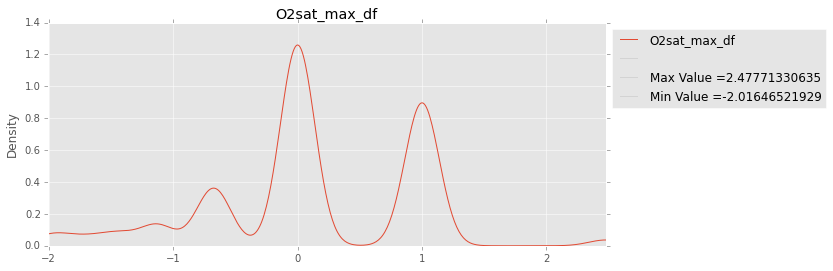

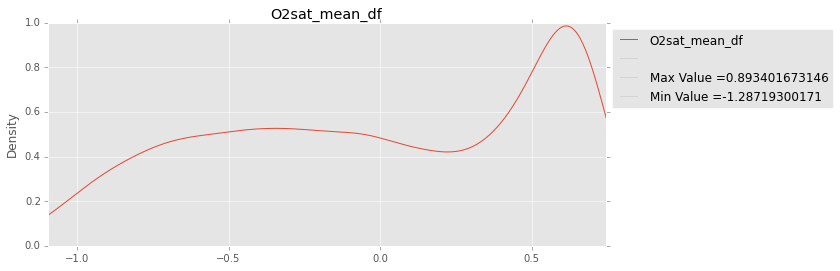

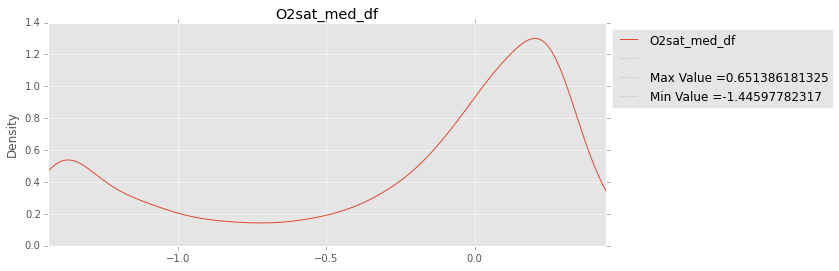

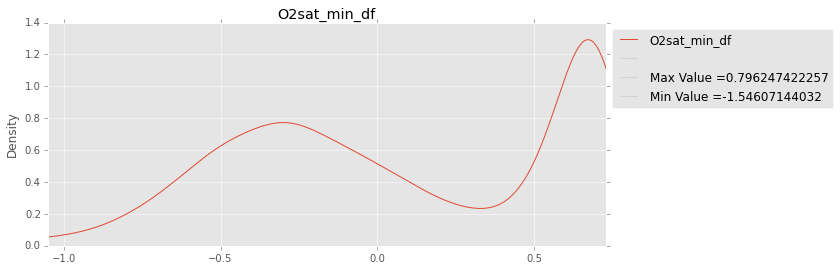

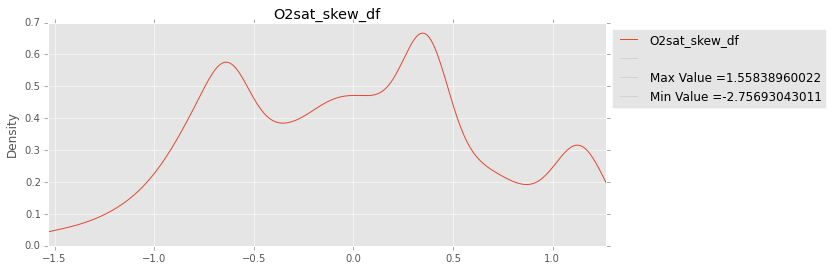

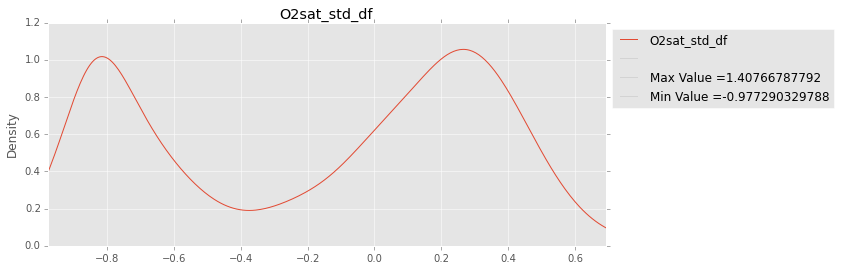

In [68]:
key = cont_dict.keys()[2]
for col in cont_dict[key].columns[2:]:
    plt.subplots(figsize=(10,4))
    cont_dict[key][col].plot.kde()
    xmin = np.percentile(cont_dict[key][col], 1)
    xmax = np.percentile(cont_dict[key][col], 99)
    plt.plot([], label=' ',color='lightgray')
    plt.plot([], label='Max Value ={}'.format(cont_dict[key][col].max()),
             color='lightgray')
    plt.plot([], label='Min Value ={}'.format(cont_dict[key][col].min()),
             color='lightgray')

    plt.xlim(xmin, xmax)
    plt.title(col)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)

#cont_dict['BP'].shape

## FEATURE SELECTION FOR CONTINUOUS/FLOAT64 DATA

In [100]:
X_cont[col].shape == cont_dict[frame].shape
print "{}   {}".format(X_cont[col].shape, cont_dict[frame].shape)

(57255,)   (57255, 8)


In [101]:
cont_feature_scores = pd.DataFrame()

for frame in cont_dict.keys():
    
    cont_dict[frame].dropna(inplace=True)
    X_cont = cont_dict[frame].drop(['hospital_expire_flag', 'icustay_id'], axis = 1)
    y_cont = cont_dict[frame]['hospital_expire_flag']
    below_zeros = list(X_cont.columns[X_cont.min() < 0])
    # SelectKBest can't deal with negative numbers so we shift any variables with negative values
    # up so that the most negative values = 0
    
    ##### THIS CODE DOES NOT SHIFT THE VALUES IN THE ORIGINAL DATAFRAME #####
    
    for col in below_zeros:
        feature_index = cont_dict[frame].columns.get_loc(col)
        col_min = X_cont[col].min()
        X_cont[col] = X_cont[col].apply(lambda x: x-col_min)
        cont_dict[frame].iloc[:,feature_index] = X_cont[col]
    
    selector = SelectKBest(k='all')
    selector.fit(X_cont, y_cont)
    d = {'pvalues': pd.Series(selector.pvalues_, index = X_cont.columns),
         'scores' : pd.Series(selector.scores_, index = X_cont.columns)
        }
    cont_feature_scores = cont_feature_scores.append(pd.DataFrame(d))

    
cont_feature_scores.sort_values(['pvalues'], axis = 0, ascending = True, inplace = True)

tops = cont_feature_scores.head(20).transpose().columns
bottoms = cont_feature_scores.tail(20).transpose().columns
display(tops[:5])
display(bottoms[:3])
display(cont_dict.keys())

Index([u'GCS_total', u'RR_med', u'RR_mean', u'Lactate_min_df', u'RR_max'], dtype='object')

Index([u'BP_Dia_max', u'O2sat_med_df', u'stay_duration'], dtype='object')

['HR',
 'TCalc',
 'O2Sat',
 'BP',
 'pH',
 'O2',
 'HWStay',
 'GCST',
 'RR',
 'LAC',
 'labpH',
 'TC']

In [102]:
cont_feature_scores

,pvalues,scores
GCS_total,0.000000e+00,1873.224252
RR_med,4.195294e-278,1285.463843
RR_mean,1.415811e-260,1202.871939
Lactate_min_df,2.221078e-175,825.002156
RR_max,4.894405e-172,787.731031
HR_std,1.637175e-138,631.089148
Lactate_mean_df,5.478301e-126,584.193530
pH_mean_df,2.497495e-125,581.972483
HR_min,5.602591e-118,535.724912
Lactate_med_df,9.754569e-114,525.208379


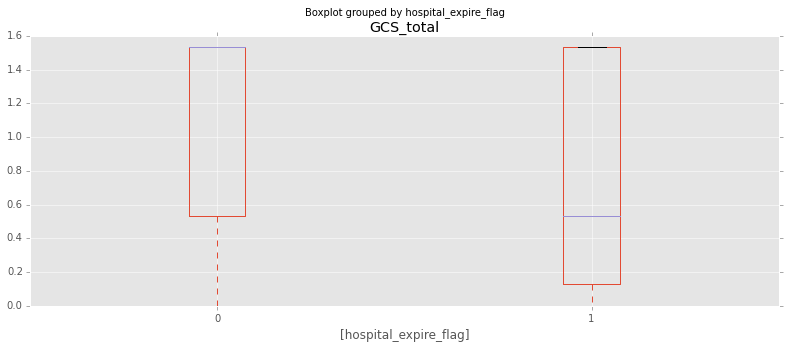

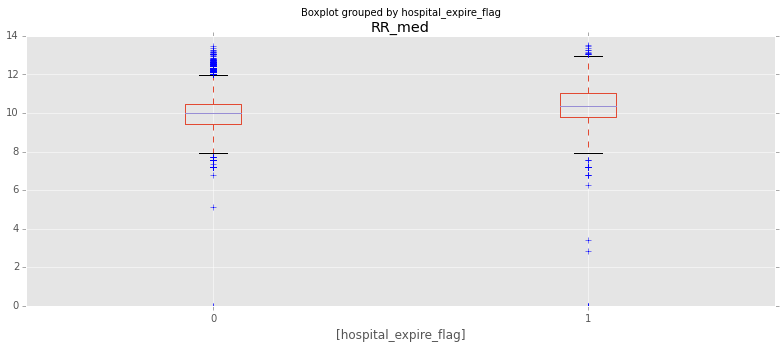

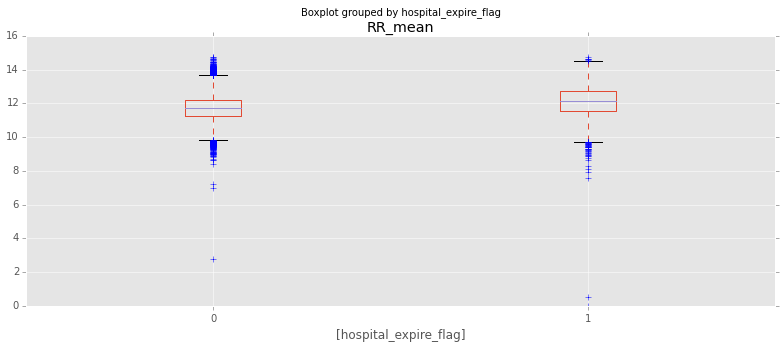

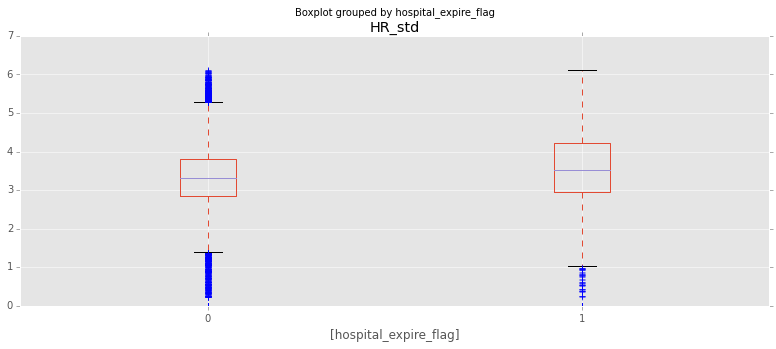

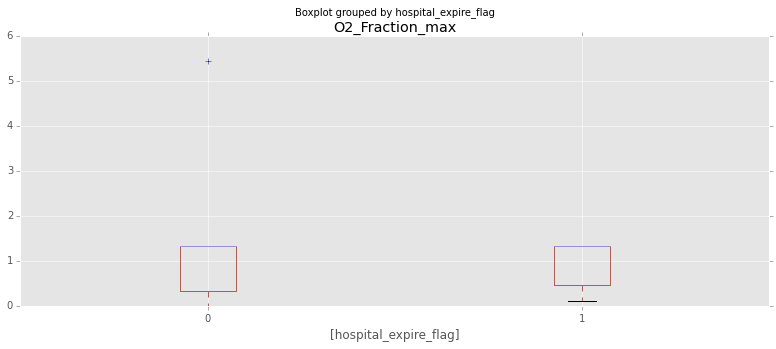

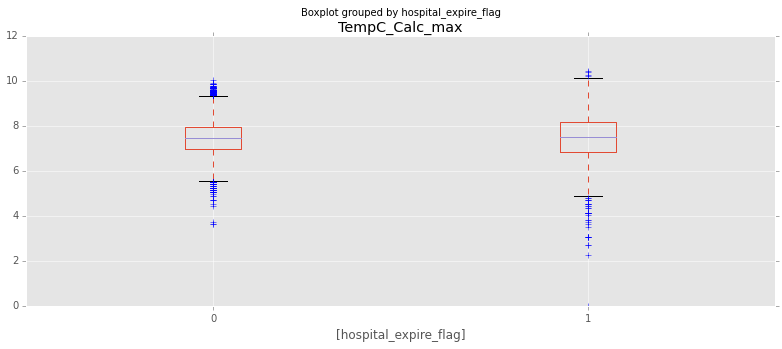

In [103]:
# PLOT 3 OF THE HIGHEST SCORED AND 3 OF THE LOWEST SCORED FEATURES TO VISUALLY VERIFY THERE ARE 
# DIFFERENCES BETWEEN SURVIVAL AND NON-SURVIVAL GROUPS

#cont_dict['RR'].plot.scatter(x='hospital_expire_flag', y='RR_med')
#for col in cont_dict['GCST'][''.columns[2:]:
cont_dict['GCST'][['hospital_expire_flag','GCS_total']].dropna().boxplot(by='hospital_expire_flag', figsize = (13,5))
cont_dict['RR'][['hospital_expire_flag','RR_med']].dropna().boxplot(by='hospital_expire_flag', figsize = (13,5))
cont_dict['RR'][['hospital_expire_flag','RR_mean']].dropna().boxplot(by='hospital_expire_flag', figsize = (13,5))
cont_dict['HR'][['hospital_expire_flag','HR_std']].dropna().boxplot(by='hospital_expire_flag', figsize = (13,5))
cont_dict['O2'][['hospital_expire_flag','O2_Fraction_max']].dropna().boxplot(by='hospital_expire_flag', figsize = (13,5))
cont_dict['TCalc'][['hospital_expire_flag','TempC_Calc_max']].dropna().boxplot(by='hospital_expire_flag', figsize = (13,5))



#data[['mort_icu', l.lower()+'_1st']].dropna().boxplot(by='mort_icu', figsize = (13,5))

In [104]:
cont_feature_scores.to_csv('Continuous_Feature_Scores.csv')

## CREATING BLOCK OF CATEGORICAL DATA FOR FEATURE SELECTION
### Cap refill and gender are not included in this block and should be evaluated separately

In [105]:
for col in cat_data.columns:
    print "{} has  {} NaN values".format(col, cat_data[col].isnull().sum())

icustay_id has  0 NaN values
hospital_expire_flag has  0 NaN values
Cap_refill has  54204 NaN values
GCS_Eye has  36828 NaN values
GCS_Motor has  36841 NaN values
GCS_Verbal has  36838 NaN values
charttimelab has  14075 NaN values
flag has  47683 NaN values
gender has  0 NaN values


In [106]:
cols = [x for x in cat_data.columns if ('GCS_' in x)]
cols.insert(0,'icustay_id')
cols.insert(1,'hospital_expire_flag')
cat_data_GCS = cat_data[cols].dropna()
print "GCS  = {}".format(cat_data_GCS.shape[0])

cols = ['icustay_id', 'hospital_expire_flag','gender']
cat_data_gender = cat_data[cols].dropna()
#cols.insert(0, cols.pop(cols.index('icustay_id')))
#cols.insert(1, cols.pop(cols.index('subject_id')))
print "gender = {}".format(cat_data_gender.shape[0])




GCS  = 23280
gender = 60131


In [107]:
cat_data_GCS.columns

Index([u'icustay_id', u'hospital_expire_flag', u'GCS_Eye', u'GCS_Motor',
       u'GCS_Verbal'],
      dtype='object')

## Create OneHotEncoded data from categorical data in GCS and Gender dataframes

In [108]:
cols = cat_data_GCS.columns[2:]
cat_data_GCS2 = pd.get_dummies(cat_data_GCS[cols], prefix= cols)

cols = cat_data_gender.columns[2:]
cat_data_gender2 = pd.get_dummies(cat_data_gender[cols], prefix= cols)



In [109]:
cat_data_GCS2.head()

,GCS_Eye_None,GCS_Eye_Spontaneously,GCS_Eye_To Pain,GCS_Eye_To Speech,GCS_Motor_Abnormal Flexion,GCS_Motor_Abnormal extension,GCS_Motor_Flex-withdraws,GCS_Motor_Localizes Pain,GCS_Motor_No response,GCS_Motor_Obeys Commands,GCS_Verbal_Confused,GCS_Verbal_Inappropriate Words,GCS_Verbal_Incomprehensible sounds,GCS_Verbal_No Response,GCS_Verbal_No Response-ETT,GCS_Verbal_Oriented
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
14,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## PERFORMING FEATURE SELECTION USING ONEHOTENCODED VARIABLES 
### SAVING P-VALUES AND SCORES FOR ALL CATEGORICAL VARIABLES IN A DATAFRAME cat_feature_Scores

In [110]:
# CREATE DICT WITH CATEGORICAL AND ASSOCIATED ONEHOTENCODED DATA REFERENCED BY EACH KEY 
cat_dict = {'GCS': [cat_data_GCS, cat_data_GCS2], 
            'Gend': [cat_data_gender, cat_data_gender2] 
            }

cat_feature_scores = pd.DataFrame()

for key in cat_dict.keys():

    X_cat = cat_dict[key][1]
    y_cat = cat_dict[key][0]['hospital_expire_flag']
   
    # SelectKBest can't deal with negative numbers so we shift any variables with negative values
    # up so that the most negative values = 0
   
    selector = SelectKBest(score_func = chi2, k='all')
    selector.fit(X_cat, y_cat)
    d = {'pvalues': pd.Series(selector.pvalues_, index = X_cat.columns),
         'scores' : pd.Series(selector.scores_, index = X_cat.columns)
        }
    cat_feature_scores = cat_feature_scores.append(pd.DataFrame(d))

cat_feature_scores.sort_values(['pvalues'], axis = 0, ascending = True, inplace = True)

tops = cat_feature_scores.head().transpose().columns
bottoms = cat_feature_scores.tail().transpose().columns
display(tops)
display(bottoms)
display(cat_dict.keys())

Index([u'GCS_Eye_None', u'GCS_Motor_No response',
       u'GCS_Verbal_No Response-ETT', u'GCS_Verbal_Oriented',
       u'GCS_Motor_Flex-withdraws'],
      dtype='object')

Index([u'GCS_Verbal_Confused', u'gender_F', u'GCS_Verbal_Inappropriate Words',
       u'GCS_Eye_To Speech', u'gender_M'],
      dtype='object')

['GCS', 'Gend']

In [112]:
cat_feature_scores.to_csv('Categorical_Feature_Scores.csv')

In [113]:
display(cat_feature_scores.index[:3])
display(cat_feature_scores.index[-3:])


Index([u'GCS_Eye_None', u'GCS_Motor_No response',
       u'GCS_Verbal_No Response-ETT'],
      dtype='object')

Index([u'GCS_Verbal_Inappropriate Words', u'GCS_Eye_To Speech', u'gender_M'], dtype='object')

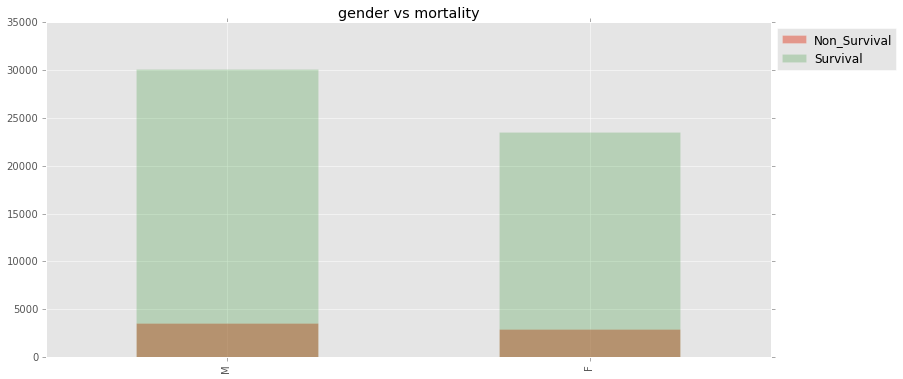

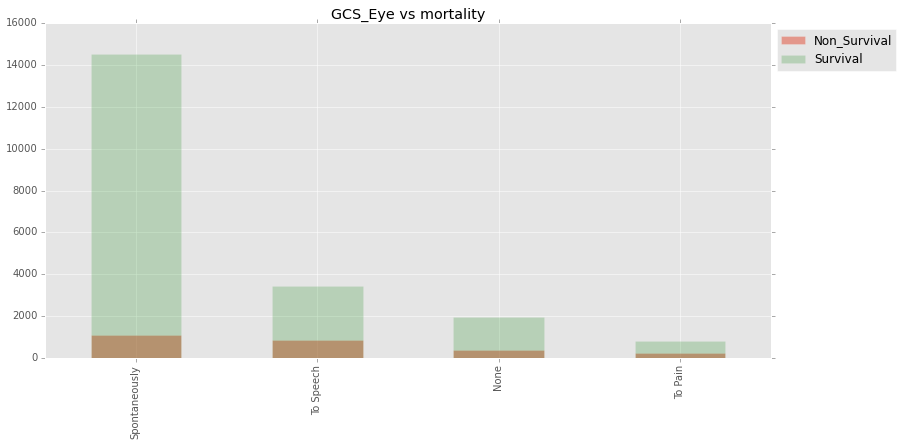

In [86]:

plt.subplots(figsize=(13,6))

cat_dict['Gend'][0]['gender'][cat_dict['Gend'][0].hospital_expire_flag ==1].value_counts().plot.bar(
        alpha = 0.5, label = 'Non_Survival')
cat_dict['Gend'][0]['gender'][cat_dict['Gend'][0].hospital_expire_flag ==0].value_counts().plot.bar(
        alpha = 0.2 , label = 'Survival', color = 'green')

plt.title('gender vs mortality')
    #plt.xlabel(l + ' ' + u)
plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)


plt.subplots(figsize=(13,6))
cat_dict['GCS'][0]['GCS_Eye'][cat_dict['GCS'][0].hospital_expire_flag ==1].value_counts().plot.bar(
        alpha = 0.5, label = 'Non_Survival')
cat_dict['GCS'][0]['GCS_Eye'][cat_dict['GCS'][0].hospital_expire_flag ==0].value_counts().plot.bar(
        alpha = 0.2 , label = 'Survival', color = 'green')

plt.title('GCS_Eye vs mortality')
    #plt.xlabel(l + ' ' + u)
plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)

## PLOTTING THE TOP 3 AND BOTTOM 3 CATEGORICAL FEATURES BY SELECTKBEST CHI2 SCORES 
### bit messy, need to clean up!


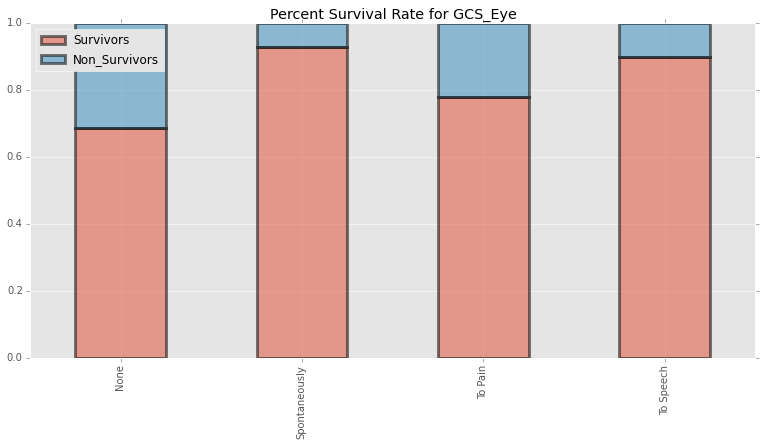

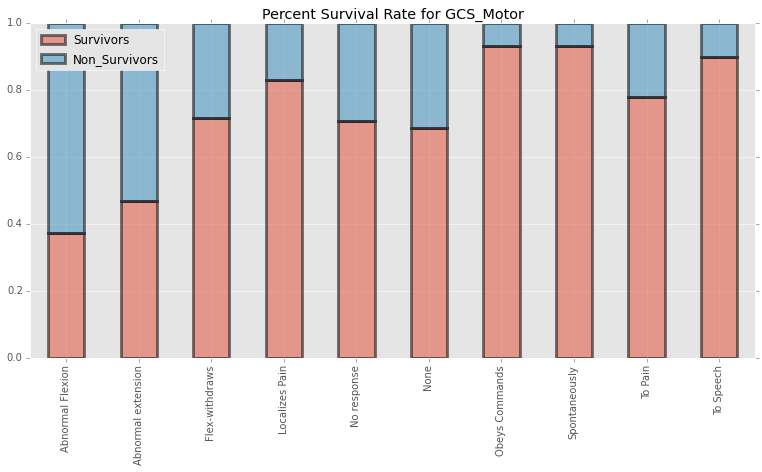

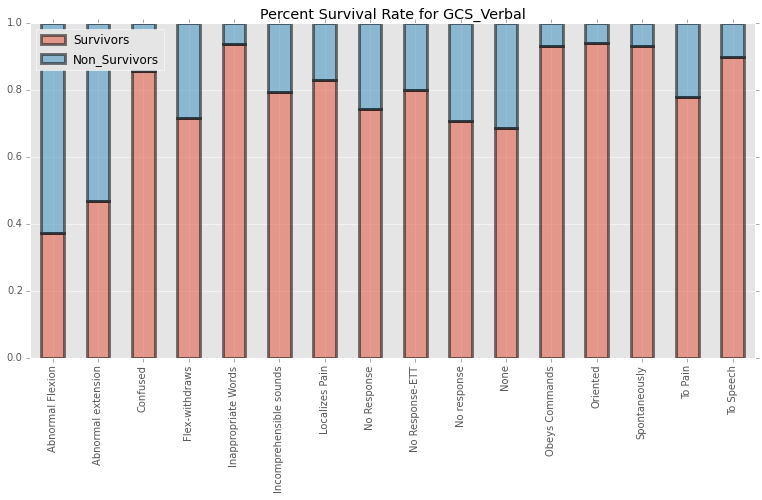

In [115]:
#
# THE ONE-HOT FRAMES DON'T HAVE HOSPITAL EXPIRED FLAG SO WE'RE PLOTTING THE RAW CATEGORICAL 
# FEATURES BASED ON THE SCORES OF THE ONEHOTENCODED FEATURES
# ALTERNATIVELY WE COULD MERGE ICUSTAY AND HOSPITAL EXPIRE FLAG INFO INTO ONE-HOT DATA. 

cat_vars = []
for col in cat_feature_scores.index[:3]:
    for col2  in cat_dict['GCS'][0].columns:
        if col2 in col:
            cat_vars.append(col2)




datadict = dict()
df = 'GCS'

for col in cat_vars: #feature_scores.index[:3]:
    
    
    
    cats = list(cat_dict[df][0][col].unique())
    for cat in cats:
        dead = cat_dict[df][0][col][(cat_dict[df][0][col] == cat) & (cat_dict[df][0].hospital_expire_flag == 1)].dropna().count()
        live = cat_dict[df][0][col][(cat_dict[df][0][col] == cat) & (cat_dict[df][0].hospital_expire_flag == 0)].dropna().count()
        total = float(live) + dead
        datadict[cat] = (live/total, dead/total)


    frame = pd.DataFrame.from_dict(datadict)
    frame.index = ['Survivors', 'Non_Survivors']
    
    frame.transpose().plot.bar(stacked = True, figsize = (13,6), edgecolor = 'black', linewidth = 3, 
                                 alpha = 0.5, title = "Percent Survival Rate for " + col)
    plt.show()














In [116]:
display(cont_dict.keys())
display(cont_feature_scores[:10])

['HR',
 'TCalc',
 'O2Sat',
 'BP',
 'pH',
 'O2',
 'HWStay',
 'GCST',
 'RR',
 'LAC',
 'labpH',
 'TC']

,pvalues,scores
GCS_total,0.000000e+00,1873.224252
RR_med,4.195294e-278,1285.463843
RR_mean,1.415811e-260,1202.871939
Lactate_min_df,2.221078e-175,825.002156
RR_max,4.894405e-172,787.731031
HR_std,1.637175e-138,631.089148
Lactate_mean_df,5.478301e-126,584.193530
pH_mean_df,2.497495e-125,581.972483
HR_min,5.602591e-118,535.724912
Lactate_med_df,9.754569e-114,525.208379


### SELECTED FEATURES
cat_feature_scores contains scores from SelectKBest analysis using chi2
cont_feature_scores contains scores from SelectKBest analysis using default
cat_data contains all categorical data while cont_data contains all continuous/float64 data
cont_features can be taken straight from cont_data but cat features have been transformed 


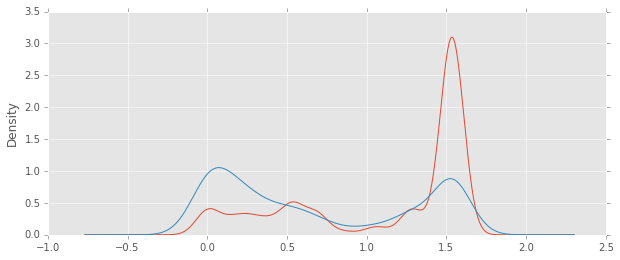

In [124]:
plt.subplots(figsize=(10,4))
cont_dict['GCST']['GCS_total'][cont_dict['GCST']['hospital_expire_flag']== 0].plot.kde()
cont_dict['GCST']['GCS_total'][cont_dict['GCST']['hospital_expire_flag']== 1].plot.kde()


In [117]:
cont_dict['GCST'].head()

,icustay_id,hospital_expire_flag,GCS_total
0,200003,0,1.535111
1,200006,0,1.535111
2,200007,0,1.535111
3,200009,0,0.535111
4,200012,0,1.535111


In [118]:
cont_dict['GCST'].groupby('hospital_expire_flag').describe()


GCS_total     icustay_id
hospital_expire_flag                                   
0                    count  25069.000000   25069.000000
                     mean       1.116852  249957.488731
                     std        0.557910   28969.598813
                     min        0.000000  200003.000000
                     25%        0.535111  224741.000000
                     50%        1.535111  249850.000000
                     75%        1.535111  275079.000000
                     max        1.535111  299999.000000
1                    count   3718.000000    3718.000000
                     mean       0.686731  249587.075578
                     std        0.614129   28834.574289
                     min        0.000000  200019.000000
                     25%        0.131811  225085.250000
                     50%        0.535111  249441.000000
                     75%        1.535111  274511.250000
                     max        1.535111  299973.000000

In [127]:
#dropping columns that weren't used in feature identification
cols = list(cat_data.columns[2:])
cols.pop(cols.index('Cap_refill'))
cols.pop(cols.index('charttimelab'))
cols.pop(cols.index('flag'))

'flag'

In [134]:
cat_select_features

['icustay_id',
 'hospital_expire_flag',
 'GCS_Eye_None',
 'GCS_Motor_No response',
 'GCS_Verbal_No Response-ETT',
 'GCS_Verbal_Oriented',
 'GCS_Motor_Flex-withdraws',
 'GCS_Motor_Abnormal Flexion',
 'GCS_Motor_Obeys Commands',
 'GCS_Eye_Spontaneously',
 'GCS_Motor_Abnormal extension',
 'GCS_Verbal_No Response']

In [129]:
cat_dummy_data = pd.get_dummies(cat_data[cols], prefix= cols)
cat_dummy_data['icustay_id'] = cat_data['icustay_id']
cat_dummy_data['hospital_expire_flag'] = cat_data['hospital_expire_flag']

cols = list(cat_dummy_data.columns)
cols.sort()
cols.insert(0, cols.pop(cols.index('icustay_id')))
cols.insert(1, cols.pop(cols.index('hospital_expire_flag')))
cat_dummy_data = cat_dummy_data[cols]
cat_dummy_data.head()

,icustay_id,hospital_expire_flag,GCS_Eye_None,GCS_Eye_Spontaneously,GCS_Eye_To Pain,GCS_Eye_To Speech,GCS_Motor_Abnormal Flexion,GCS_Motor_Abnormal extension,GCS_Motor_Flex-withdraws,GCS_Motor_Localizes Pain,GCS_Motor_No response,GCS_Motor_Obeys Commands,GCS_Verbal_Confused,GCS_Verbal_Inappropriate Words,GCS_Verbal_Incomprehensible sounds,GCS_Verbal_No Response,GCS_Verbal_No Response-ETT,GCS_Verbal_Oriented,gender_F,gender_M
0,200001,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,200003,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,200006,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,200007,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,200009,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [185]:
cat_feature_scores

,pvalues,scores
GCS_Eye_None,5.232463e-253,1154.293737
GCS_Motor_No response,8.864588e-134,605.867145
GCS_Verbal_No Response-ETT,8.252634e-107,481.898700
GCS_Verbal_Oriented,2.480360e-87,392.404059
GCS_Motor_Flex-withdraws,2.063374e-75,337.659578
GCS_Motor_Abnormal Flexion,4.555559e-73,326.897426
GCS_Motor_Obeys Commands,9.110050e-69,307.152600
GCS_Eye_Spontaneously,1.455077e-60,269.504572
GCS_Motor_Abnormal extension,4.793173e-43,189.183199
GCS_Verbal_No Response,7.098710e-36,156.350027


In [342]:

# cat_select_features = list(cat_feature_scores[cat_feature_scores.scores > 350].index)
# SELECTING ALL FEATURES FOR NEURAL NET INPUT
cat_select_features = list(cat_feature_scores[cat_feature_scores.pvalues < 0.05].index)

cat_select_features.insert(0, 'icustay_id')
#could leave this out to avoid duplicates when merging w/ cont data later
cat_select_features.insert(1,'hospital_expire_flag') 

cat_select_data = cat_dummy_data[cat_select_features]
display(cat_select_data.shape)
cat_select_data.head()


(60131, 16)

,icustay_id,hospital_expire_flag,GCS_Eye_None,GCS_Motor_No response,GCS_Verbal_No Response-ETT,GCS_Verbal_Oriented,GCS_Motor_Flex-withdraws,GCS_Motor_Abnormal Flexion,GCS_Motor_Obeys Commands,GCS_Eye_Spontaneously,GCS_Motor_Abnormal extension,GCS_Verbal_No Response,GCS_Eye_To Pain,GCS_Motor_Localizes Pain,GCS_Verbal_Incomprehensible sounds,GCS_Verbal_Confused
0,200001,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,200003,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,200006,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,200007,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,200009,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [343]:
# SELECTING ALL FEATURES FOR NN

#cont_select_features = list(cont_feature_scores[cont_feature_scores.scores > 600].index)



# CODE TO ELIMINATE COLUMNS BEGINNING WITH LOWEST SCORED VARIABLES FIRST, UNTIL WE HAVE > 5000 SAMPLES WITH 
# NO NAN VALUES
monkey = -1
cont_select_features = cont_feature_scores.index
cont_select_data = cont_data[cont_select_features].dropna()

while cont_select_data.shape[0] < 5000:
    cont_select_features = list(cont_feature_scores.index)[:monkey]
    cont_select_data = cont_data[cont_select_features].dropna()
    monkey -= 1



cont_select_features.insert(0, 'icustay_id')
cont_select_features.insert(1,'hospital_expire_flag')
cont_select_data = cont_data[cont_select_features].dropna()
display(cont_select_data.shape)
cont_select_data.head()

(6318, 25)

,icustay_id,hospital_expire_flag,GCS_total,RR_med,RR_mean,Lactate_min_df,RR_max,HR_std,Lactate_mean_df,pH_mean_df,...,pH_std_df,BP_Dia_min,Lactate_max_df,BP_Mean_min,TempC_Calc_std,pH_med_df,pH_min,pH2_min,pH2_mean,pH_mean
1,200003,0,15.0,33.0,29.288889,2.6,39.0,16.161433,3.933333,6.998333,...,0.979600,0.0,5.1,64.0,1.007599,7.380,7.36,7.36,7.398,7.398
20,200030,0,15.0,20.0,20.250000,1.4,28.0,9.974120,3.530769,6.910000,...,0.940248,52.0,6.8,67.0,0.346061,7.365,7.37,7.37,7.390,7.390
32,200045,0,15.0,21.0,20.520000,3.8,27.0,11.593699,5.378571,7.282857,...,0.057652,38.0,7.8,64.0,0.568092,7.290,7.19,7.19,7.260,7.260
40,200059,0,11.0,14.0,15.297872,1.0,35.0,12.059560,1.762500,7.102500,...,0.851918,50.0,2.8,63.0,1.197007,7.395,7.37,7.37,7.420,7.420
61,200091,0,7.0,17.0,16.238095,2.1,25.0,6.952636,2.733333,7.420000,...,0.087178,53.0,3.6,73.0,0.356838,7.460,7.46,7.46,7.470,7.470


In [344]:

cont_select_data2 = cont_select_data.set_index(['icustay_id'], inplace = False)
cat_select_data2 = cat_select_data.set_index(['icustay_id'], inplace = False)
cat_select_data2.drop(['hospital_expire_flag'], axis = 1, inplace = True)


all_select_data = cont_select_data2.merge(cat_select_data2, left_index = True, right_index = True, 
                                         how='left', sort = True, suffixes = ('cont', 'cat'))

all_select_data.dropna(inplace = True)
all_select_data.shape

(6318, 38)

In [345]:
monkey = all_select_data.groupby('hospital_expire_flag')['RR_med'].count()

float(monkey[1])/monkey[0]

0.26587858144660387

In [346]:
# SCALING ALL_SELECT_DATA2 TO 0-1

all_select_data2 = all_select_data.copy()
min_max_scalar = preprocessing.MinMaxScaler()
all_select_data2.iloc[:,1:] = min_max_scalar.fit_transform(all_select_data2.iloc[:,1:])
all_select_data2.head()

,hospital_expire_flag,GCS_total,RR_med,RR_mean,Lactate_min_df,RR_max,HR_std,Lactate_mean_df,pH_mean_df,HR_min,...,GCS_Motor_Flex-withdraws,GCS_Motor_Abnormal Flexion,GCS_Motor_Obeys Commands,GCS_Eye_Spontaneously,GCS_Motor_Abnormal extension,GCS_Verbal_No Response,GCS_Eye_To Pain,GCS_Motor_Localizes Pain,GCS_Verbal_Incomprehensible sounds,GCS_Verbal_Confused
icustay_id,,,,,,,,,,,,,,,,,,,,,
200003,0,1.000000,0.733333,0.672240,0.365079,0.543860,0.434631,0.406312,0.507266,0.541353,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
200030,0,1.000000,0.444444,0.419268,0.174603,0.350877,0.268235,0.358671,0.470588,0.624060,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
200045,0,1.000000,0.466667,0.426825,0.555556,0.333333,0.311791,0.577346,0.625408,0.481203,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
200059,0,0.666667,0.311111,0.280672,0.111111,0.473684,0.324319,0.149408,0.550519,0.518797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
200091,0,0.333333,0.377778,0.306987,0.285714,0.298246,0.186978,0.264300,0.682353,0.436090,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## SVM CLASSIFICATION USING ALL SELECT DATA

In [340]:
X_train, X_test, y_train, y_test = train_test_split(all_select_data2[all_select_data2.columns[1:]], 
                                                    all_select_data2['hospital_expire_flag'], 
                                                    test_size = 0.20, random_state = 42)

clf_SVC = svm.SVC(C=0.5, cache_size=200, class_weight={1:3}, coef0=0.0,
    decision_function_shape=None, degree=3, gamma='auto', kernel='rbf', 
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False).fit(X_train, y_train)

'''
scores = cross_val_score(clf_SVC, all_select_data[all_select_data.columns[1:]], 
                         all_select_data['hospital_expire_flag'], cv=5)
display(scores)  
'''
display(clf_SVC.score(X_test, y_test))
y_predsSVM = clf_SVC.predict(X_test)
metrics.confusion_matrix(y_test, y_predsSVM)



0.83907262188885101

array([[2312,  148],
       [ 324,  149]])

In [341]:
# MULTI-LAYER PERCEPTRON CLASSIFIER ON ORIGINAL FEATURES

X_train, X_test, y_train, y_test = train_test_split(all_select_data2[all_select_data2.columns[1:]], 
                                                    all_select_data2['hospital_expire_flag'], 
                                                    test_size = 0.30, random_state = 42)   

parameters = {'activation':('identity', 'logistic', 'tanh', 'relu'), 
              'solver':('lbfgs', 'sgd', 'adam'), 
              'hidden_layer_sizes':((7,3), (5,2))
             }
mlp = MLPClassifier(alpha=1e-6, learning_rate = 'adaptive',
                    hidden_layer_sizes=(7,3), random_state=1)
clf = GridSearchCV(mlp, parameters)
clf.fit(X_train,y_train)
'''
for result in clf.cv_results_.keys():
    print "{}      {}".format(result, clf.cv_results_[result])
'''
display(clf.score(X_test, y_test))
y_predsMLP = clf.predict(X_test)
display(clf.best_params_)
display(metrics.confusion_matrix(y_test, y_predsMLP))


0.84564673789497613

{'activation': 'logistic', 'hidden_layer_sizes': (7, 3), 'solver': 'lbfgs'}

array([[3608,   63],
       [ 616,  112]])

## PCA AND CLASSIFICATION ON ALL SELECT DATA

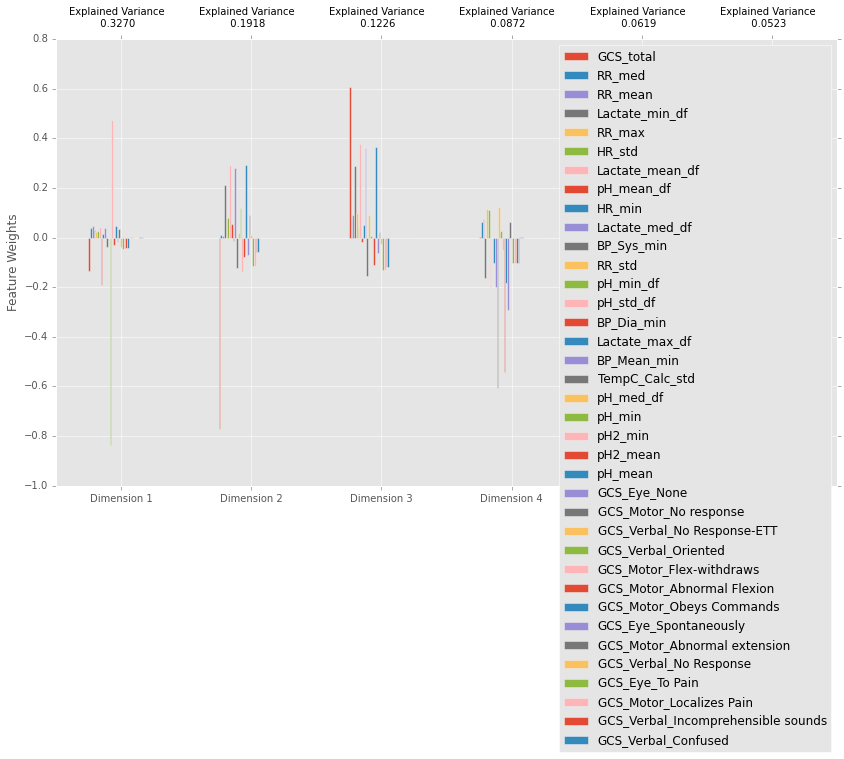

In [348]:
#pca = PCA(n_components = 4).fit(data2)
pca = PCA(n_components = 6).fit(all_select_data2[all_select_data2.columns[1:]])

# Generate PCA results plot
pca_results = vs.pca_results(all_select_data2[all_select_data2.columns[1:]], pca)

In [350]:
all_reduced_data = pca.transform(all_select_data2[all_select_data2.columns[1:]])

# Create a DataFrame for the reduced data
all_reduced_data = pd.DataFrame(all_reduced_data, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4',
                                                    'Dimension 5', 'Dimension 6'])
                                #,'Dimension 7', 'Dimension 8']) #, 
                                                            #'Dimension 9', 'Dimension 10'])
all_reduced_data.head()

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,0.655235,-0.146470,0.668825,0.420784,0.046613,-0.484769
1,0.407025,-0.333761,0.358744,-0.245747,-0.071182,-0.095558
2,-0.340882,0.133332,0.776615,-0.205648,0.039195,0.177126
3,0.551760,-0.240996,-0.090585,-0.011402,-0.028418,-0.101862
4,-0.423878,0.200828,-0.237719,-0.273570,-0.102277,-0.226890


In [351]:
# GAUSSIAN NAIVE BAYES CLASSIFIER WITH PCA COMPONENTS DERIVED FROM ALL DATA


X_train, X_test, y_train, y_test = train_test_split(all_reduced_data, 
                                                    all_select_data['hospital_expire_flag'], 
                                                    test_size = .30, random_state = 42)


### create classifier
clf_GNB = GaussianNB()
### fit the classifier on the training features and labels
clf_GNB.fit(X_train, y_train)
    ### return the fit classifier

nb_score = clf_GNB.score(X_test, y_test) 

print nb_score
y_predsGNB = clf_GNB.predict(X_test)
metrics.confusion_matrix(y_test, y_predsGNB)



0.783755274262


array([[1383,  110],
       [ 300,  103]])

In [352]:
# SUPPORT VECTOR MACHINE
SVC = svm.SVC(cache_size=200, coef0=0.0, gamma='auto', max_iter=-1, 
                  probability=False, random_state=42, shrinking=True, tol=0.001, 
                  verbose=False)

parameters = {'C':(.2, .5, .7, 1), 
              'kernel':('linear', 'poly', 'rbf', 'sigmoid'),
              'degree':(2,3,4), 
              'class_weight':({1:1.5}, {1:1.75}, {1:2}, {1:2.25}, {1:2.5}), 
              'decision_function_shape':('ovo', 'ovr')
              
             }

clf = GridSearchCV(SVC, parameters)
clf.fit(X_train,y_train)
'''
for result in clf.cv_results_.keys():
    print "{}      {}".format(result, clf.cv_results_[result])
'''
display(clf.score(X_test, y_test))
y_predsMLP = clf.predict(X_test)
display(clf.best_params_)
display(metrics.confusion_matrix(y_test, y_predsMLP))

print "The percentage of survivors in this test sample is {}".format((1 - float(y_test.sum())/y_test.count())*100)


0.80696202531645567

{'C': 0.2,
 'class_weight': {1: 1.75},
 'decision_function_shape': 'ovo',
 'degree': 2,
 'kernel': 'rbf'}

array([[1467,   26],
       [ 340,   63]])

The percentage of survivors in this test sample is 78.7447257384


In [353]:
print 'monkey'

monkey


## PCA AND CLASSIFICATION USING SELECT CATEGORICAL DATA

In [ ]:
cat_select_data3 = cat_select_data.set_index(['icustay_id'], inplace = False)

In [ ]:
#pca = PCA(n_components = 4).fit(data2)
pca = PCA(n_components =4).fit(cat_select_data3[cat_select_data3.columns[1:]])

# Generate PCA results plot
pca_results = vs.pca_results(cat_select_data3[cat_select_data3.columns[1:]], pca)

In [ ]:
reduced_cat_data = pca.transform(cat_select_data3[cat_select_data3.columns[1:]])

# Create a DataFrame for the reduced data
reduced_cat_data = pd.DataFrame(reduced_cat_data, columns = ['Dimension 1', 'Dimension 2', 
                                                             'Dimension 3', 'Dimension 4'])
                                                    #'Dimension 5', 'Dimension 6','Dimension 7', 'Dimension 8'])
reduced_cat_data.head()

In [ ]:
# Training using 80% of data and testing using 20%. 



X_train, X_test, y_train, y_test = train_test_split(reduced_cat_data, 
                                                    cat_select_data3['hospital_expire_flag'], 
                                                    test_size = .40, random_state = 42)


### create classifier
clf_GNB = GaussianNB()
### fit the classifier on the training features and labels
clf_GNB.fit(X_train, y_train)
    ### return the fit classifier

nb_score = clf_GNB.score(X_test, y_test) 

print nb_score
y_predsGNB = clf_GNB.predict(X_test)
metrics.confusion_matrix(y_test, y_predsGNB)



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data2[data2.columns[1:]], data2['mort_icu'], 
                                                    test_size = 0.30, random_state = 42)

clf_SVC = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape=None, degree=3, gamma='auto', kernel='rbf', 
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False).fit(X_train, y_train)

scores = cross_val_score(clf_SVC, data2[data2.columns[1:]], data2['mort_icu'], cv=5)
display(scores)  

In [ ]:
monkey